# Prepare Data

In [74]:
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
import numpy as np
import os

folder_path = os.path.dirname('/mnt/c/Users/mikel/Desktop/grid_output/')
runs_path = os.path.join(folder_path, '2020jfo.log')

# Read data
runs_df = pd.read_json(runs_path, lines=True)
wav = None
seds = []
for run in runs_df.itertuples():
    sed_df = pd.read_csv(os.path.join(folder_path, run.id + '_sed.csv'))
    seds.append(sed_df['L_density'].values)
    if wav is None:
        wav = sed_df['wavelength'].values

# Prepare for interpolation
def convert(v):
    return u.Quantity(v).value
X = runs_df.drop('id', axis=1).reset_index(drop=True).map(convert)
y = np.array(seds)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# View Data

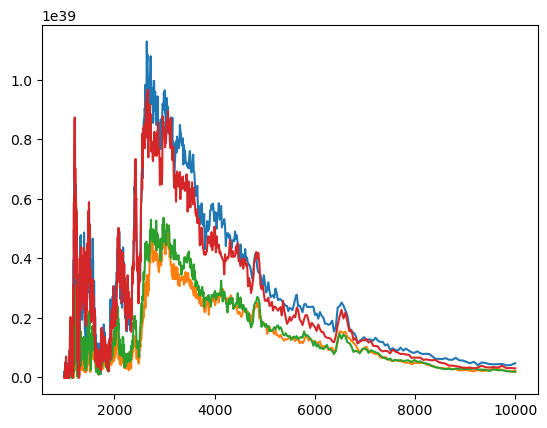

In [75]:
for index, entry in enumerate(X):
    plt.plot(wav, y[index])
plt.show()

# Fit Models

In [76]:
# Linear interpolator
from scipy.interpolate import LinearNDInterpolator
interp = LinearNDInterpolator(X_train, y_train)

In [ ]:
# Find hyperparameters
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

if False:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(
            max_iter=10000, activation='relu', alpha=1e-3, learning_rate_init=1e-2, random_state=0, early_stopping=False,
        ))
    ])

    s = 450 # 2/3 of data, training size
    param_grid = {
        'mlp__hidden_layer_sizes': [(200, 100, 50, 25, 12), (200, 100, 50, 25)],
        #'mlp__activation': ['relu', 'tanh'],
        #'mlp__alpha': [1e-5, 1e-4, 1e-3],
        #'mlp__learning_rate_init': [1e-3, 1e-2]
    }

    search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    search.fit(X, y)
    best_model = search.best_estimator_

    results = pd.DataFrame(search.cv_results_).sort_values('rank_test_score')
    print(results[['param_mlp__hidden_layer_sizes', 'std_test_score']])

    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Test MSE:", mse)
    print(search.best_params_)


In [179]:
# MLPRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp = MLPRegressor(
    max_iter=10000, activation='relu', alpha=1e-3, learning_rate_init=1e-2, hidden_layer_sizes=(200, 100)#, early_stopping=True
)
model = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', mlp)
])
model.fit(X_train, y_train)
#print(mlp.best_validation_score_)

# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print("Test MSE:", mse)

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(alpha=0.001, hidden_layer_sizes=(200, 100),
                              learning_rate_init=0.01, max_iter=10000))])

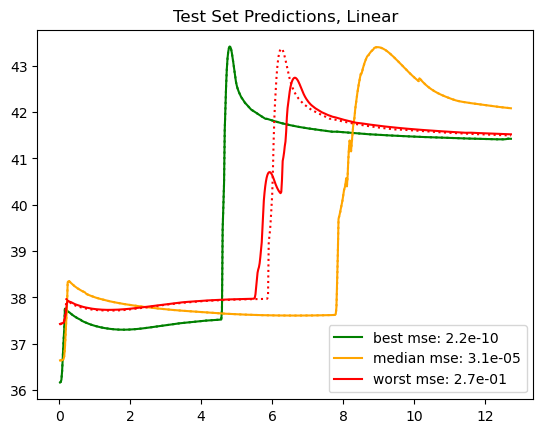

mean mse: 2.1e-02


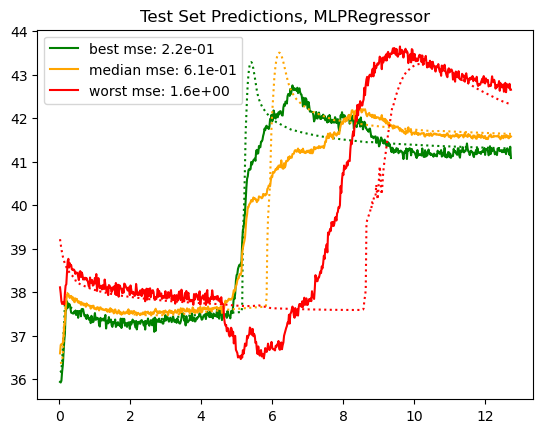

mean mse: 6.6e-01


In [180]:
def evaluate_predictions(y_test, y_pred, x_axis, title):
    mse = []
    tests = []
    preds = []

    # Filter out predictions that contain NaN values
    for i in range(len(y_test)):
        y_t = y_test[i]
        y_p = y_pred[i]
        if np.isnan(y_p).sum() == 0:
            mse.append(mean_squared_error(y_t, y_p))
            tests.append(y_t)
            preds.append(y_p)

    # Sort by mse
    total = len(mse)
    sorted_indices = np.argsort(mse)
    min_i = sorted_indices[0]
    med_i = sorted_indices[total // 2]
    max_i = sorted_indices[total - 1]

    # Plot best, median, and worst predictions
    plt.plot(x_axis, preds[min_i], c='green', label='best mse: ' + f'{mse[min_i]:.1e}')
    plt.plot(x_axis, tests[min_i], c='green', ls=':')
    plt.plot(x_axis, preds[med_i], c='orange', label='median mse: ' + f'{mse[med_i]:.1e}')
    plt.plot(x_axis, tests[med_i], c='orange', ls=':')
    plt.plot(x_axis, preds[max_i], c='red', label='worst mse: ' + f'{mse[max_i]:.1e}')
    plt.plot(x_axis, tests[max_i], c='red', ls=':')
    plt.title(title)
    plt.legend()
    plt.show()
    
    print('mean mse: ' + f'{np.mean(mse):.1e}')

evaluate_predictions(y_test, interp(X_test), t, 'Test Set Predictions, Linear')
evaluate_predictions(y_test, model.predict(X_test), t, 'Test Set Predictions, MLPRegressor')

# Fit Observed

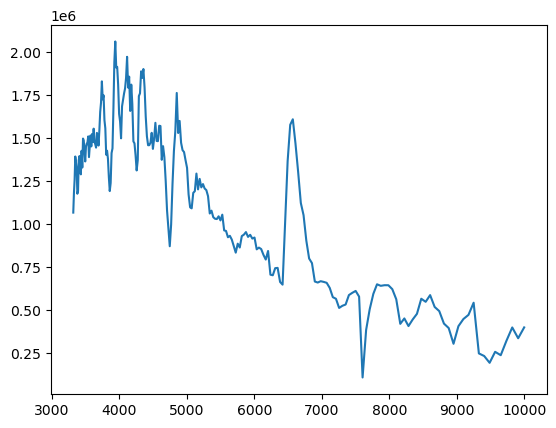

inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
inf
[]


/home/mikel/anaconda3/envs/tardis/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [79]:
param_names = ['log_lsun', 't_exp', 'v_start', 't_inner']
limits = [(8, 10.5), (11, 15), (5800, 6600), (11800, 15800)]

# Get observed data
from scipy.interpolate import interp1d
obs_df = pd.read_csv('2020jfo-FLOYDS-S-2020-05-19.csv', comment="#")
y_obs = interp1d(obs_df["wavelength"], obs_df["flux"], bounds_error=False)(wav)

plt.plot(wav, y_obs)
plt.show()

# Find best fit
results = []

def f(x):
    X_mod = pd.DataFrame([x], columns=param_names)
    y_mod = interp(list(X_mod.values))[0]
    mask = ~(np.isnan(y_mod) | np.isnan(y_obs))
    if np.sum(mask) == 0:
        print('inf')
        return np.inf
    else:
        mse = np.mean((y_mod[mask] - y_obs[mask])**2)
        results.append({'mse': mse, 'X': X_mod, 'y': y_mod})
        return mse

from scipy.optimize import minimize
start = np.mean(X_train, axis=0)
result = minimize(f, x0=start, bounds=limits)
results = sorted(results, key=lambda x: x['mse'])
print(results)


In [61]:
start = [(min + max) / 2 for min, max in limits]
y_mod = interp(start)[0]
print(start)
print(y_mod)

[9.25, 13.0, 6200.0, 13800.0]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan 

In [57]:
for i in range(3):
    y_mod = results[i]['y']

    plt.plot(wav, y_obs, label='observed')
    plt.plot(wav, y_mod, label='model')
    plt.title('Predicted vs Observed: ' + str(i))
    plt.legend()
    plt.show()

    print('mse:', results[i]['mse'])
    print('X:', results[i]['X'])

IndexError: list index out of range